## **CVRP Assignment 3 - part 2**

In this assignment we will explore both vision and multimodal generative AI models and their capabilities.

### **2. Text-to-Image Generation [25 pts]**

Text-to-image models based on the concept of diffusion processes has made a huge impact in this task.

We will explore the capabilities of the StableDiffusion model.

In [4]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton flash-attn diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01:010m


In [6]:
!pip install --upgrade diffusers transformers accelerate
!pip install --upgrade huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.1
    Uninstalling huggingface-hub-0.26.1:
      Successfully uninstalled huggingface-hub-0.26.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.1
    Uninstalling tokenizers-0.20.1:
      Successfully uninstalled tokenizers-0.20.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.0
    Uninstalling transformers-4.46.0:
      Successfully uninstalled transformers-4.46.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.16.1 requires datasets>=3.0.0, which is not installed.
trl 0.16.1 requires rich, which

#### **2.1 Loading and dissecting the Stable Diffusion v2.1 Model**

The StableDiffusionv2.1 model is a relatively performant model that uses an auto-encoder coupled with a model that learns the diffusion process on the latent space.

In [3]:
import torch
from diffusers import StableDiffusionPipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
#device = torch.device("cpu")
#dtype = torch.float32

model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype = dtype)
pipe = pipe.to(device)

print(pipe)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/stable-diffusion-2-1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



#### **2.2 AutoEncoding with a Pre-trained Variational AutoEncoder [5 pts]**

Given the following image, we will use the pre-trained variational autoencoder (VAE) that comes with the StableDiffusion model to encode the image and then add random gaussian noise centered at zero with a standard deviation of 2.0 to the latent space of the VAE and then decode back the output to show its effect and how to use the VAE.

Task:

1. Add random guassian noise from $N(0, 2)$ to the latent space of the VAE

Your result should be similar to the following.

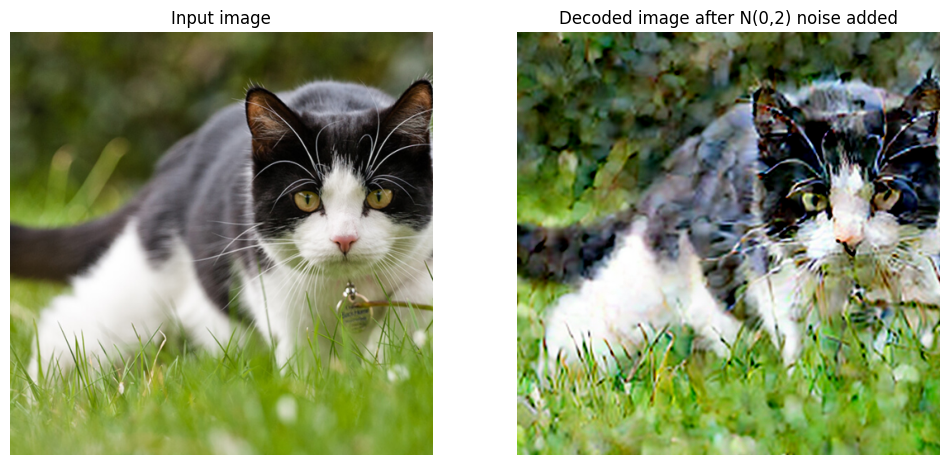

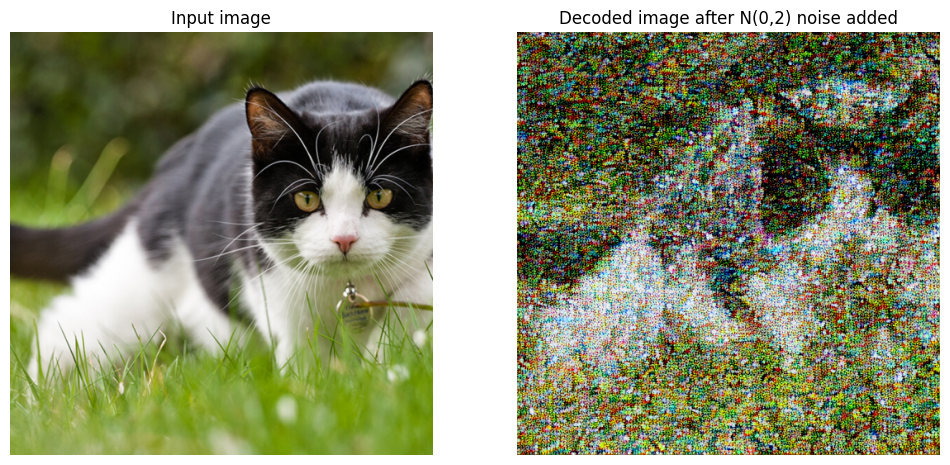

In [4]:
import io, requests
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Use a cute cat from online image
img_url = 'https://www.purina.co.uk/sites/default/files/2020-12/Understanding%20Your%20Cat%27s%20Body%20LanguageTEASER.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

with torch.no_grad():

  # Define the preprocessing pipeline
  transform = transforms.Compose([
      transforms.Resize(512),  # Resize the image to 256x256
      transforms.CenterCrop(512),  # Crop the image to 224x224
      transforms.ToTensor(),  # Convert the image to a PyTorch tensor
  ])

  image = transform(img_pil).to(device).to(dtype)

  # Add Gaussian noise with mean 0 and std 2
  noise = torch.randn_like(image) * 2.0
  noisy_image = image + noise
  
  # Get the posterior (noisy latents)
  posterior = pipe.vae.encode(noisy_image.unsqueeze(0)).latent_dist.sample()
  
  # Scale the latents
  posterior = posterior * pipe.vae.config.scaling_factor
  
  # Decode the image
  output = pipe.vae.decode(posterior / pipe.vae.config.scaling_factor).sample
  output = output.squeeze(0)

  # Plot side by side.
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.title("Input image")
  plt.imshow(image.data.permute(1, 2, 0).float().cpu()); plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.title("Decoded image after N(0,2) noise added")
  output = output.clip(0, 1)
  plt.imshow(output.data.permute(1, 2, 0).float().cpu()); plt.axis("off")
  plt.show()

#### **2.4 Generating an image [5 pts]**

Next we generate a sample image by passing a prompt through the pipeline. The diffusion model starts from a noisy image and then tries to progressively a) Remove noise and b) Maximize the alignment of the output image with the input text prompt. The denoising process happens in the latent space so the latent representation must be further decoded into an image with an image-only pre-trained variational autoencoder (VAE).

Task:

1. Complete the `callback` function to decode for every timesteps.

Your output should be similar to following image.

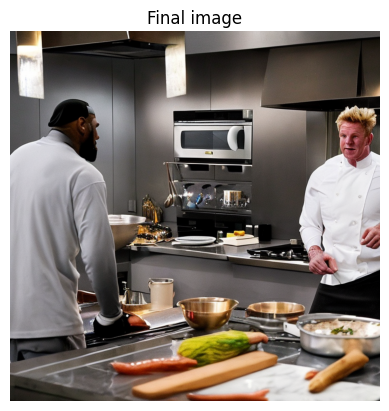

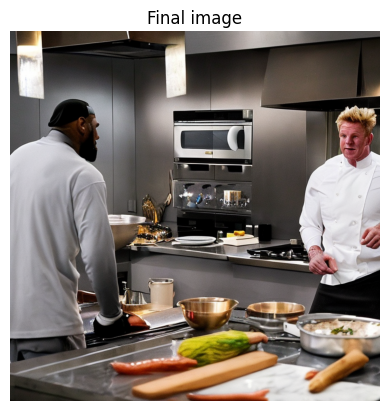

In [5]:
import torchvision, time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

prompt = "Lebron James is cooking in a kitchen with Gordon Ramsay staring at him"

def callback(pipe, step, timestep, data):
  if step % 5 == 0:
    # we plot out the image for every 5 timesteps
    latents = data['latents']
    # Scale and decode the image latents with vae
    latents = 1 / pipe.vae.config.scaling_factor * latents
    image = pipe.vae.decode(latents).sample
    # Convert to PIL image
    image = pipe.image_processor.postprocess(image, output_type="pil")

    clear_output(wait = True)
    plt.figure(); plt.title("Iteration %d" % step);
    plt.imshow(image[0]);plt.axis('off'); plt.show();
  return data

images = pipe(prompt = prompt,
              num_inference_steps = 50,
              generator = torch.Generator(device).manual_seed(123),
              guidance_scale = 7.5,
              callback_on_step_end = callback).images

clear_output(wait = True)
plt.figure(); plt.title("Final image");
plt.imshow(images[0]);plt.axis('off'); plt.show();
images[0].save("scene.jpg")

#### **2.5 Analyzing and dissecting the model [5 pts]**

The StableDiffusion-v2.1 model has several components that it depends on. Answer the following general questions:


1. What was the native image output size that was used to train this model?
___

2. What is the shape of the latent space use by this model for native resolution input?
___
3. What is the size of the vocabulary used to represent the input text?
___
4. What is the maximum token-length of the sequence that the text encoder can encode?
___

**Note:** None of the answers depend on the example provided in the previous cell or any particular input except when indicated in the question.

#### **2.6 Analyzing and dissecting other models [5 pts]**

The StableDiffusion-v2.1 model is good but it is far from the state-of-the-art today. You can find it in the leaderboard here: https://artificialanalysis.ai/text-to-image/arena?tab=Leaderboard. Answer the same questions as in Section 2.5 for the top 4 models in this leaderboard for which this information is possible to obtain, i.e. there is either a technical report publicly available providing these details or the model is open source and you can inspect it. Fill the table below using the markup and format provided.

| Model Name| Training Image Size | Shape of Latent Space | Vocabulary Size | Text Length |
|----------|----------|----------|----------| ----------|
| Model 1 | $A \times B$ | $C \times D$ | $N$ | $M$|
| Model 2 | - | - | - |- |
| Model 3 | - | - | - |- |
| Model 4 | - | - | - |- |
| StableDiffusionv2.1 | _ | _ | _ | _|

#### **2.7 Generate an image [5 pts]**

Tasks:

1. Try to generate an image such as the one shown below. To get full points there should be: 1) a capybara, 2) the capybara has to be wearing a hat and a bowtie 3) the capybara has to be in front of a brick wall, 4) the aesthetic quality of the output should be preserved.

2. You must include your generated image and compute the CLIPScore (using your prompt) and Quality score for your image.

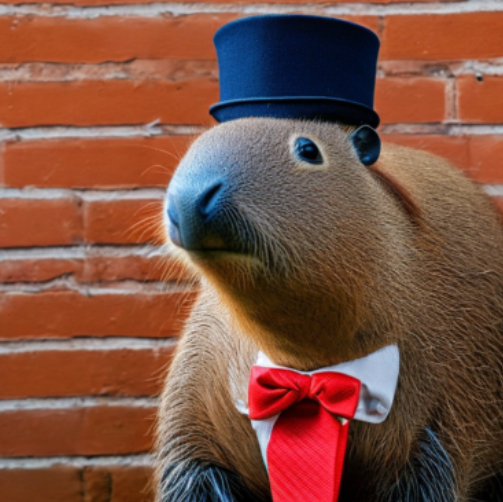

  0%|          | 0/50 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP Score for generated image: 34.3831


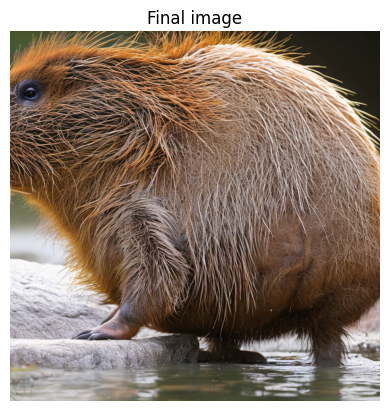

In [6]:
# task 1 : Code, prompts, etc to generate the image.
# task 2 : CLIP score calculation of the generated image and your prompt

#### Your code here ####
from transformers import CLIPProcessor, CLIPModel
import torch

# Task 1: Generate image of a capybara
prompt = "A cute capybara sitting in a hot spring, steam rising, relaxing, high quality, detailed"

# Generate the image
images = pipe(
    prompt=prompt,
    num_inference_steps=50,
    generator=torch.Generator(device).manual_seed(42),
    guidance_scale=7.5
).images

# Task 2: Calculate CLIP score
# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Prepare image and text for CLIP
inputs = clip_processor(
    text=[prompt],
    images=images[0],
    return_tensors="pt",
    padding=True
).to(device)

# Calculate CLIP score
with torch.no_grad():
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    clip_score = logits_per_image.item()

print(f"CLIP Score for generated image: {clip_score:.4f}")
########################

plt.figure(); plt.title("Final image");
plt.imshow(images[0]);plt.axis('off'); plt.show();
images[0].save("capybara.jpg")

## Note: Always stop your instance runtime to avoid running out of quotas:

In [7]:
from google.colab import runtime
runtime.unassign()

ModuleNotFoundError: No module named 'google.colab'